# Environment

In [ ]:
!pip install gdown
!pip install keras

In [ ]:
!gdown https://drive.google.com/uc?id=1rf-12hne2dpE1j4Li3h1t2dUPZIucbHp

Downloading...
From: https://drive.google.com/uc?id=1rf-12hne2dpE1j4Li3h1t2dUPZIucbHp
To: /content/cf_matrix.py
100% 4.09k/4.09k [00:00<00:00, 20.2MB/s]


In [ ]:
!rm -rf /content/code_smells_datasets
!gdown --folder https://drive.google.com/drive/folders/1CcZmw-jwAc1Fc9LOgxYCSZPC0vQWjkXn?usp=drive_link
!cd /content/code_smells_datasets && tar -xvf train.tar && rm -rf train.tar
!cd /content/code_smells_datasets && tar -xvf test.tar && rm -rf test.tar

Retrieving folder list
Processing file 1YmnQ3EDSMXAUuK8JRuvBrHBjPDWE79jd test.tar
Processing file 1SToYP2zha858yTtzyvLUveFWlqMBw5k6 train.tar
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1YmnQ3EDSMXAUuK8JRuvBrHBjPDWE79jd
To: /content/code_smells_datasets/test.tar
100% 14.4M/14.4M [00:00<00:00, 38.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SToYP2zha858yTtzyvLUveFWlqMBw5k6
To: /content/code_smells_datasets/train.tar
100% 51.9M/51.9M [00:00<00:00, 66.9MB/s]
Download completed
train/
train/C#_CaseB_Train_1.csv
train/C++_CaseB_Train_1.csv
train/Java_CaseB_Train_1.csv
test/
test/C#_CaseB_Test_1.csv
test/C++_CaseB_Test_1.csv
test/Java_CaseB_Test_1.csv


In [ ]:
!mkdir -p /content/models
!mkdir -p /content/results
!mkdir -p /content/results/confusion_matrix
!mkdir -p /content/results/predictions

In [ ]:
%run /content/cf_matrix.py

# Research

In [ ]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D
from keras.utils import pad_sequences

from sklearn.metrics import confusion_matrix
from numpy.random import seed

In [ ]:
COMMENTS = [
    604,
    612,
    618,
    621,
    648
]
RANDOM_STATE = 33
LANGUAGES = ['Java', 'C#', 'C++']
SMELLS = [
    {'name': 'HarmfulVsClean', 'suffix': 'hc', 'padding_tokens': 28191},
]

MAIN_DIR = '/content'
TRAIN_DIR = os.path.join(MAIN_DIR, 'code_smells_datasets', 'train')
TEST_DIR = os.path.join(MAIN_DIR, 'code_smells_datasets', 'test')
MODELS_DIR = os.path.join(MAIN_DIR, 'models')
RESULTS_DIR = os.path.join(MAIN_DIR, 'results')
DATA_FILE = os.path.join(RESULTS_DIR, 'data.csv')

# Helper functions

In [ ]:
def to_array_int(token_str):
    return list(map(int, filter(len, token_str.split(' '))))

def padding_tokens(values, size):
    return pad_sequences(values, maxlen=size, padding='post', truncating='post')

def remove_comments(tokens):
    return list(filter(lambda value: value not in COMMENTS, tokens))

def pre_process_token_str(token_str):
    result = {}
    try:
      if type(token_str) == list:
        return remove_comments(token_str)
      result = remove_comments(to_array_int(token_str))
    except:
      print(token_str)
    return result

def init_data():
    return {
        'model': [],
        'dataset': [],
        'smell_name': [],
        'model_language': [],
        'target_language': [],
        'n_test_samples': [],
        'n_train_samples': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'tn': [],
        'fp': [],
        'fn': [],
        'tp': []
    }

def append_data_file(data):
    pd.DataFrame(data).to_csv(DATA_FILE, index=False, mode='a', header=not os.path.exists(DATA_FILE))

def select_samples(smell_csv, n_samples):
    dataset = pd.DataFrame(columns=['smell', 'tokens'])

    positive = smell_csv.query('smell == 1').sample(n_samples, random_state=RANDOM_STATE)
    negative = smell_csv.query('smell == 0').sample(n_samples, random_state=RANDOM_STATE)

    samples = pd.concat([positive, negative], axis=0)

    dataset['tokens'] = samples['tokens']
    dataset['smell'] = samples['smell']

    return dataset

def process(data, dataset_id, dataset, x, y, smell, languages, target_language, model_name2, model_n_sample_val=None):
    fig = plt.figure(figsize=(20, 5))
    i = 131

    for model_language in languages:
        if type(model_n_sample_val) == dict:
            model_n_sample = model_n_sample_val[smell['name']]
            model_n_sample = model_n_sample[model_language]
        else:
            model_n_sample = model_n_sample_val

        model_name = '{}_{}_{}_{}'.format(model_language, model_name2, model_n_sample, smell['suffix'])
        model_path = os.path.join(MODELS_DIR, model_name)

        if not os.path.exists(model_path):
            print('model not found: {}'.format(model_path))
            continue

        print('loading model: {}, dataset_id: {}'.format(model_name, dataset_id))

        pre_trained_model = load_model(model_path)

        loss, accuracy = pre_trained_model.evaluate(padding_tokens(x.values, smell['padding_tokens']), y, verbose=0)

        data['model'].append(model_name)
        data['n_train_samples'].append(model_n_sample)
        data['dataset'].append(dataset_id)
        data['smell_name'].append(smell['name'])
        data['model_language'].append(model_language)
        data['target_language'].append(target_language)
        data['n_test_samples'].append(len(x))
        data['accuracy'].append(accuracy)

        predictions = pre_trained_model.predict(padding_tokens(x.values, smell['padding_tokens']))
        output_name = 'model_{}_dataset_{}'.format(model_name, dataset_id)

        try:
            cf_matrix = confusion_matrix(y, (predictions > 0.5).astype("int32"))
            tn, fp, fn, tp = cf_matrix.ravel()
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * (precision * recall) / (precision + recall)

            data['precision'].append(precision)
            data['recall'].append(recall)
            data['f1'].append(f1)
            data['tn'].append(tn)
            data['fp'].append(fp)
            data['fn'].append(fn)
            data['tp'].append(tp)

            fig.add_subplot(i)
            plt.title('{}: {} to {}'.format(smell['name'], model_language, target_language))

            make_confusion_matrix(cf_matrix,
                                  group_names=['TN', 'FP', 'FN', 'TP'],
                                  categories=['No', 'Yes'],
                                  sum_stats=False)



            dataset.loc[:, 'predict_value'] = predictions
            dataset.loc[:, 'predict_class'] = (predictions > 0.5).astype("int32")
        except Exception as e:
            print(e)
            data['precision'].append(0)
            data['recall'].append(0)
            data['f1'].append(0)
            print('Fail to build MF')

        dataset.to_csv(os.path.join(RESULTS_DIR, 'predictions', output_name))

        i = i + 1

    plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix', 'model_{}_dataset_{}.png'.format(model_name, dataset_id)))
    plt.close()

## Exemple: to_array_int

In [ ]:
to_array_int('300 200 100')

[300, 200, 100]

## Example: padding_tokens

In [ ]:
tokens = [
    [300, 200, 100], # length < 5
    [300, 200, 100, 123, 123], # length = 5
    [300, 200, 100, 123, 123, 909, 123, 1923, 2813] # length > 5
]

padding_tokens(tokens, 5)

array([[300, 200, 100,   0,   0],
       [300, 200, 100, 123, 123],
       [300, 200, 100, 123, 123]], dtype=int32)

# RQ1: How effective is transfer learning to detect code smells?

## Functions

In [ ]:
def perceptron(padding):
    np.random.seed(RANDOM_STATE)
    model = Sequential()
    model.add(Embedding(20000, 8, input_length=padding))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def train_all_samples(languages, dataset_name, smell, model_function, model_name, model_n):
    for language in languages:

        print('training model: {} {} {} {}'.format(language, smell['name'], dataset_name, model_name))

        dataset_path = os.path.join(TRAIN_DIR, '{}_{}_{}.csv'.format(language, smell['name'], dataset_name))

        if not os.path.exists(dataset_path):
            print('train dataset not found: {} {}'.format(smell['name'], language))
            continue

        dataset = pd.read_csv(dataset_path, index_col=False, dtype = {'tokens': str})

        dataset['tokens'] = dataset['tokens'].map(lambda value: pre_process_token_str(value))

        x = dataset.iloc[:, -1]
        y = dataset.iloc[:, -2]

#         if os.path.exists(os.path.join(MODELS_DIR, '{}_{}_{}_{}'.format(language, model_name, len(x), smell['suffix']))):
#             print('model already exists')
#             continue

        x_train = padding_tokens(x.values, smell['padding_tokens'])
        y_train = y

        model = model_function(smell['padding_tokens'])

        model.fit(x_train, y_train, epochs=100, verbose=0)

        model.save(os.path.join(MODELS_DIR, '{}_{}_{}_{}'.format(language, model_name, len(x), smell['suffix'])))

        model_n[smell['name']].update({language: len(x)})

    else:
        return model_n

In [ ]:
def transfer_learning(model_languages, target_language, model_name, model_n_sample):
    print('transfer learning: {} {}'.format(model_languages, target_language))

    data = init_data()

    for smell in SMELLS:
        print(smell['name'])
        for test in os.listdir(TEST_DIR):
            if test.startswith(target_language):
                dataset_path = os.path.join(TEST_DIR, test)
                dataset = pd.read_csv(os.path.join(dataset_path), index_col=False)

                dataset['tokens'] = dataset['tokens'].map(lambda value: pre_process_token_str(value))

                x = dataset.iloc[:, -1]
                y = dataset.iloc[:, -2]

                process(data, test, dataset, x, y, smell, model_languages, target_language, model_name, model_n_sample)

    return data

## Training Perceptron models

In [ ]:
model_n_dict = {}
for smell in SMELLS:
    model_n_dict[smell['name']] = {}
    model_n_size = train_all_samples(LANGUAGES, 'Train_1', smell, perceptron, 'perceptron1', model_n_dict)

training model: Java CaseB Train_1 perceptron1


training model: C# CaseB Train_1 perceptron1


training model: C++ CaseB Train_1 perceptron1


## Transfer Learning

{'CaseB': {'Java': 2160, 'C#': 960, 'C++': 70}}
transfer learning: ['Java', 'C#', 'C++'] Java
CaseB
loading model: Java_perceptron1_2160_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 73ms/step
loading model: C#_perceptron1_960_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 67ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_70_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 65ms/step


<ipython-input-9-58724c2c7d3f>:96: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)


transfer learning: ['Java', 'C#', 'C++'] C#
CaseB
loading model: Java_perceptron1_2160_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 62ms/step
loading model: C#_perceptron1_960_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 61ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_70_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 60ms/step
transfer learning: ['Java', 'C#', 'C++'] C++
CaseB
loading model: Java_perceptron1_2160_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 93ms/step
loading model: C#_perceptron1_960_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 95ms/step
loading model: C++_perceptron1_70_cb, dataset_id: C++_CaseB_Test_1.csv


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


1/1 [==============================] - 0s 85ms/step


<ipython-input-9-58724c2c7d3f>:96: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)


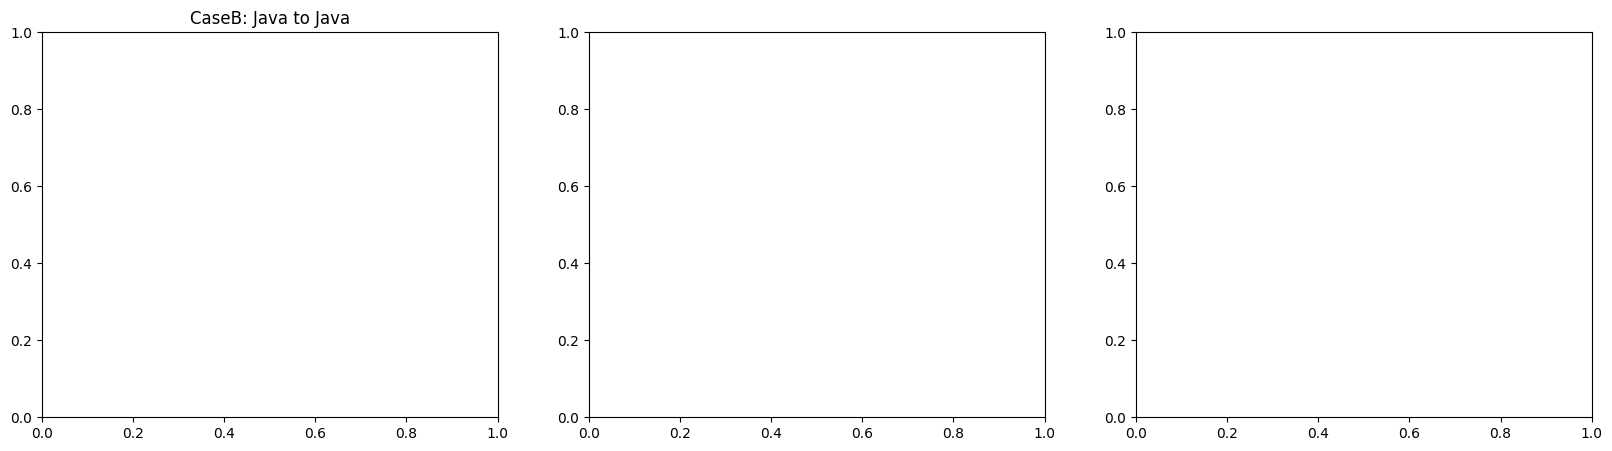

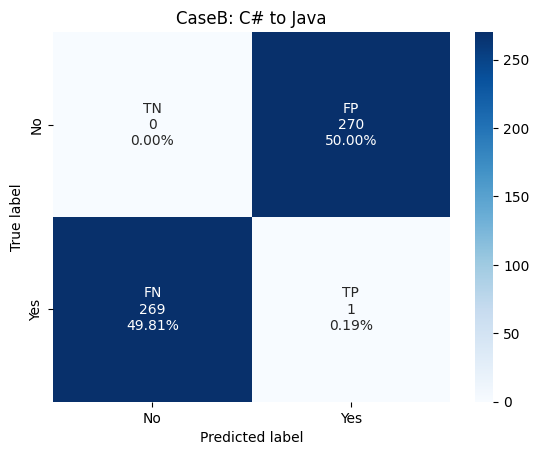

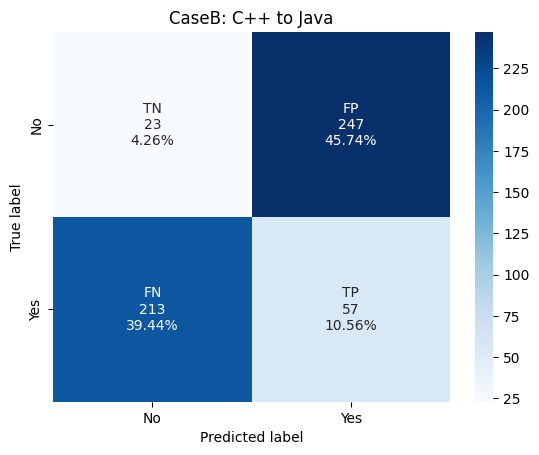

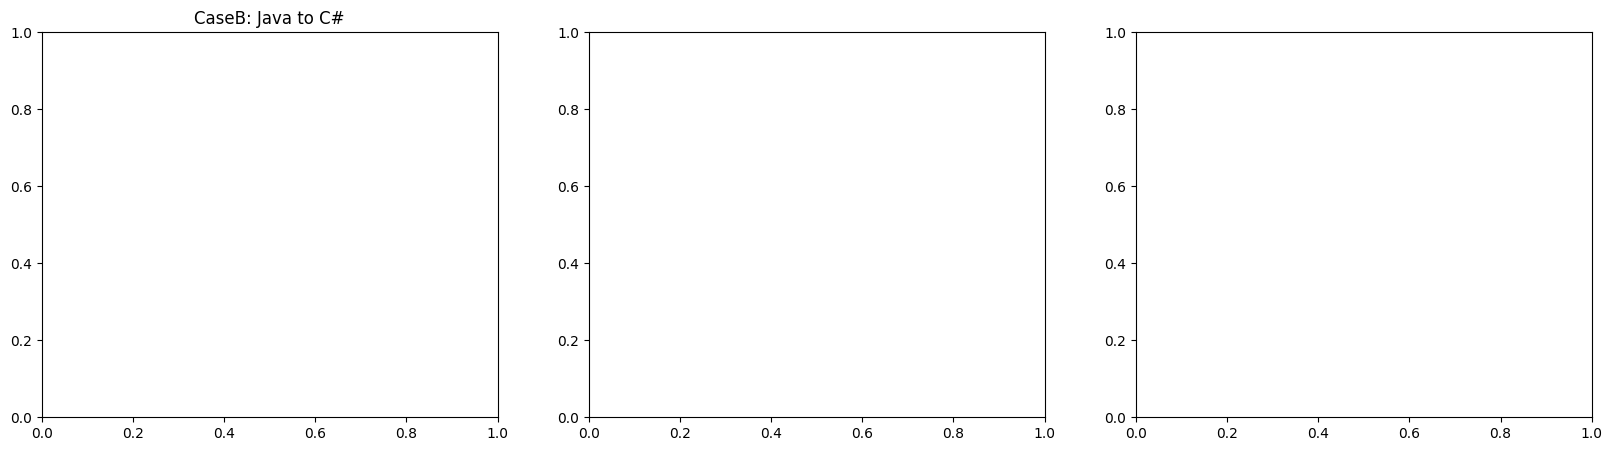

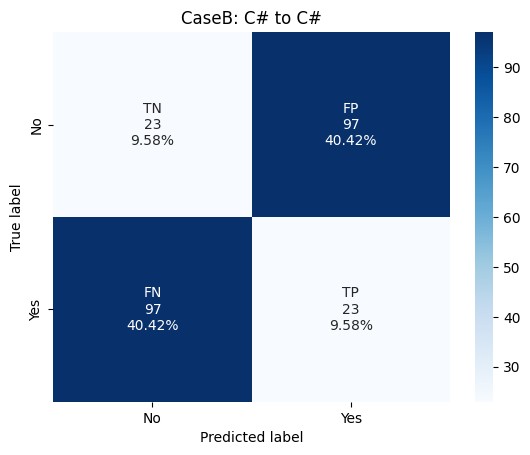

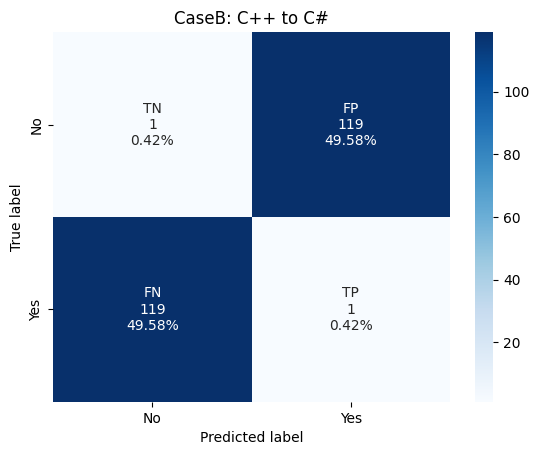

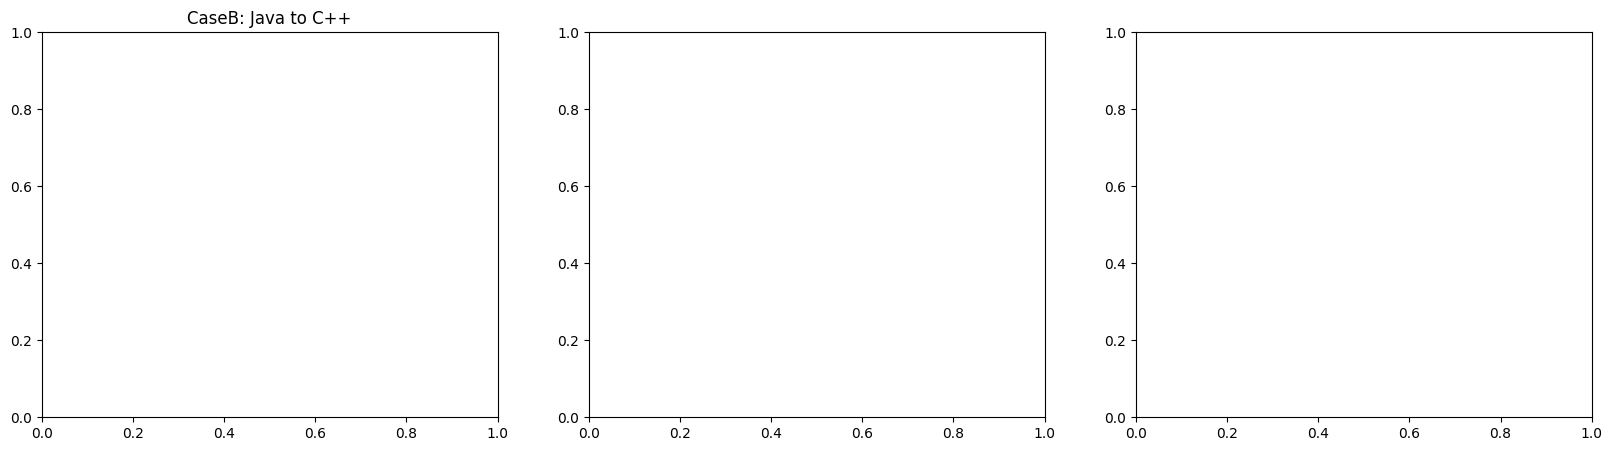

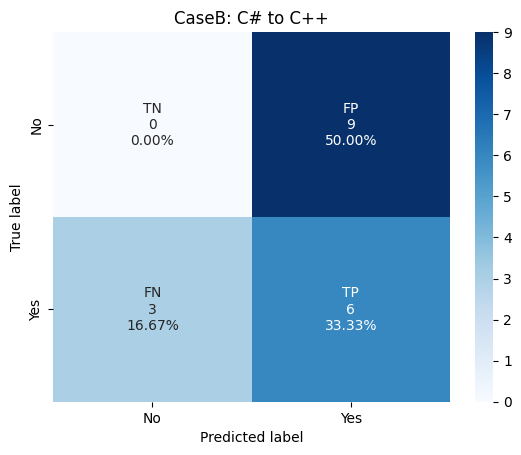

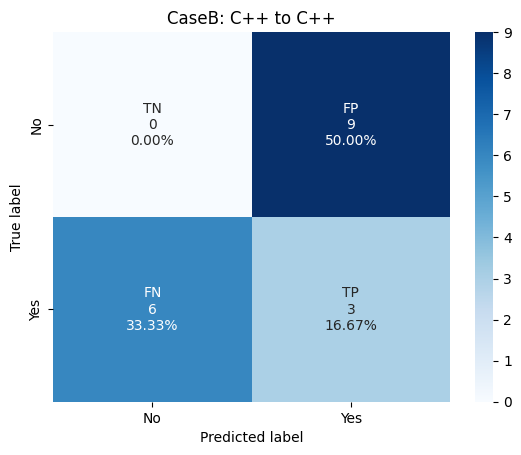

In [ ]:
results = []
print(model_n_size)

for target_language in LANGUAGES:
    results.append(transfer_learning(LANGUAGES, target_language, 'perceptron1', model_n_size))

# for target_language in LANGUAGES:
#     results.append(transfer_learning(LANGUAGES, target_language, 'perceptron1', 64))

In [ ]:
# Saving the results of those models when evaluated using Test datasets
for result in results:
    append_data_file(result)

# RQ2: How influential are programming languages constructs to detect code smells by using transfer learning?

In [ ]:
dataset = pd.read_csv(os.path.join(RESULTS_DIR, 'data.csv'), index_col=False)
dataset = dataset.query("smell_name == 'ComplexMethod' and dataset.str.contains('ComplexMethod')", engine="python")
pd.set_option('display.max_rows', len(dataset) + 1)
dataset.sort_values(by=['f1'], ascending=True)

,model,dataset,smell_name,model_language,target_language,n_test_samples,n_train_samples,accuracy,precision,recall,f1,tn,fp,fn,tp


# RQ3: How efficient is transfer learning to detect code smells?

## Functions

In [ ]:
def train_n_samples(languages, n_samples, dataset_name, smell, model_function, model_name):
    for language in languages:
        for n in n_samples:
            name = '{}_{}_{}_{}'.format(language, model_name, n * 2, smell['suffix'])
            model_path = os.path.join(MODELS_DIR, name)

            if os.path.exists(model_path):
                continue

            print('training model (n samples): {} {} {} {} {}'.format(language, smell['name'], n * 2, dataset_name, model_name))

            dataset_path = os.path.join(TRAIN_DIR, '{}_{}_{}.csv'.format(language, smell['name'], dataset_name))

            if not os.path.exists(dataset_path):
                continue

            dataset = pd.read_csv(dataset_path)

            pos_smell_df = dataset.query('smell == 1')
            pos_size = len(pos_smell_df)
            neg_smell_df = dataset.query('smell == 0')
            neg_size = len(neg_smell_df)

            if pos_size < 2 * n or neg_size < 2 * n:
                print('Sample size too small, skipping')
                continue

            samples = select_samples(dataset, n)
            samples['tokens'] = samples['tokens'].map(lambda value: pre_process_token_str(value))

            x = samples.iloc[:, -1]
            y = samples.iloc[:, -2]

            x_train = padding_tokens(x.values, smell['padding_tokens'])
            y_train = y

            model = model_function(smell['padding_tokens'])

            model.fit(x_train, y_train, epochs=100, verbose=0)

            model.save(model_path)

def transfer_learning_n_samples(model_languages, target_language, dataset_name, smell, model_name):
    print('transfer learning (n samples): {} {} {}'.format(model_languages, target_language, smell['name']))

    data = init_data()

    for n in [4, 8, 16, 32, 64, 128, 256, 512]:
        tests = map(lambda t: t.format(target_language, smell['name'], dataset_name) + '.csv', [
            '{}_{}_{}',
        ])
        for test in tests:
            dataset_path = os.path.join(TEST_DIR, test)

            if not dataset_path:
                print('not exists', dataset_path)
                continue

            dataset = pd.read_csv(dataset_path, index_col=False)

            dataset['tokens'] = dataset['tokens'].map(lambda value: pre_process_token_str(value))

            x = dataset.iloc[:, -1]
            y = dataset.iloc[:, -2]

            process(data, test, dataset, x, y, smell, model_languages, target_language, model_name, n)

    return data


## Training Perceptron models

In [ ]:
# train_n_samples(['Python'], [2, 4, 8, 16, 32, 64, 128, 256], 'Train_1', SMELLS[0], perceptron, 'perceptron1')
for smell in SMELLS:
    train_n_samples(LANGUAGES, [2, 4, 8, 16, 32, 64, 128, 256], 'Train_1', smell, perceptron, 'perceptron1')

training model (n samples): Java CaseB 4 Train_1 perceptron1


training model (n samples): Java CaseB 8 Train_1 perceptron1


training model (n samples): Java CaseB 16 Train_1 perceptron1


training model (n samples): Java CaseB 32 Train_1 perceptron1


training model (n samples): Java CaseB 64 Train_1 perceptron1


training model (n samples): Java CaseB 128 Train_1 perceptron1


training model (n samples): Java CaseB 256 Train_1 perceptron1


training model (n samples): Java CaseB 512 Train_1 perceptron1


training model (n samples): C# CaseB 4 Train_1 perceptron1


training model (n samples): C# CaseB 8 Train_1 perceptron1


training model (n samples): C# CaseB 16 Train_1 perceptron1


training model (n samples): C# CaseB 32 Train_1 perceptron1


training model (n samples): C# CaseB 64 Train_1 perceptron1


training model (n samples): C# CaseB 128 Train_1 perceptron1


training model (n samples): C# CaseB 256 Train_1 perceptron1


training model (n samples): C# CaseB 512 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C++ CaseB 4 Train_1 perceptron1


training model (n samples): C++ CaseB 8 Train_1 perceptron1


training model (n samples): C++ CaseB 16 Train_1 perceptron1


training model (n samples): C++ CaseB 32 Train_1 perceptron1


training model (n samples): C++ CaseB 64 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C++ CaseB 128 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C++ CaseB 256 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C++ CaseB 512 Train_1 perceptron1
Sample size too small, skipping


## Transfer Learning

transfer learning (n samples): ['Java', 'C#', 'C++'] Java CaseB
loading model: Java_perceptron1_4_cb, dataset_id: Java_CaseB_Test_1.csv


17/17 [==============================] - 1s 67ms/step
loading model: C#_perceptron1_4_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 67ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_4_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 66ms/step
loading model: Java_perceptron1_8_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 70ms/step
loading model: C#_perceptron1_8_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 70ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_8_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 66ms/step


<ipython-input-9-58724c2c7d3f>:96: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)


loading model: Java_perceptron1_16_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 66ms/step
loading model: C#_perceptron1_16_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 2s 114ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_16_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 65ms/step


<ipython-input-9-58724c2c7d3f>:96: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)


loading model: Java_perceptron1_32_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 66ms/step
loading model: C#_perceptron1_32_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 65ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_32_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 68ms/step


<ipython-input-9-58724c2c7d3f>:96: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)


loading model: Java_perceptron1_64_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 66ms/step
loading model: C#_perceptron1_64_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 63ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


model not found: /content/models/C++_perceptron1_64_cb
loading model: Java_perceptron1_128_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 64ms/step
loading model: C#_perceptron1_128_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 64ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


model not found: /content/models/C++_perceptron1_128_cb
loading model: Java_perceptron1_256_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 63ms/step
loading model: C#_perceptron1_256_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 1s 65ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


model not found: /content/models/C++_perceptron1_256_cb
loading model: Java_perceptron1_512_cb, dataset_id: Java_CaseB_Test_1.csv
17/17 [==============================] - 2s 110ms/step
model not found: /content/models/C#_perceptron1_512_cb
model not found: /content/models/C++_perceptron1_512_cb
transfer learning (n samples): ['Java', 'C#', 'C++'] C# CaseB
loading model: Java_perceptron1_4_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 59ms/step


/content/cf_matrix.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


loading model: C#_perceptron1_4_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 60ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_4_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 62ms/step
loading model: Java_perceptron1_8_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 58ms/step
loading model: C#_perceptron1_8_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 72ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_8_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 60ms/step
loading model: Java_perceptron1_16_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 61ms/step
loading model: C#_perceptron1_16_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 59ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_16_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 67ms/step
loading model: Java_perceptron1_32_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 58ms/step
loading model: C#_perceptron1_32_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 58ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: C++_perceptron1_32_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 61ms/step
loading model: Java_perceptron1_64_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 60ms/step
loading model: C#_perceptron1_64_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 98ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


model not found: /content/models/C++_perceptron1_64_cb
loading model: Java_perceptron1_128_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 59ms/step
loading model: C#_perceptron1_128_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 64ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


model not found: /content/models/C++_perceptron1_128_cb
loading model: Java_perceptron1_256_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 57ms/step
loading model: C#_perceptron1_256_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 61ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


model not found: /content/models/C++_perceptron1_256_cb
loading model: Java_perceptron1_512_cb, dataset_id: C#_CaseB_Test_1.csv
8/8 [==============================] - 1s 104ms/step
model not found: /content/models/C#_perceptron1_512_cb
model not found: /content/models/C++_perceptron1_512_cb
transfer learning (n samples): ['Java', 'C#', 'C++'] C++ CaseB
loading model: Java_perceptron1_4_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 91ms/step
loading model: C#_perceptron1_4_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 87ms/step
loading model: C++_perceptron1_4_cb, dataset_id: C++_CaseB_Test_1.csv


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


1/1 [==============================] - 0s 92ms/step
loading model: Java_perceptron1_8_cb, dataset_id: C++_CaseB_Test_1.csv


1/1 [==============================] - 0s 104ms/step
loading model: C#_perceptron1_8_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 100ms/step
loading model: C++_perceptron1_8_cb, dataset_id: C++_CaseB_Test_1.csv


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


1/1 [==============================] - 0s 92ms/step
loading model: Java_perceptron1_16_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 95ms/step
loading model: C#_perceptron1_16_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 90ms/step
loading model: C++_perceptron1_16_cb, dataset_id: C++_CaseB_Test_1.csv


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


1/1 [==============================] - 0s 90ms/step
loading model: Java_perceptron1_32_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 87ms/step
loading model: C#_perceptron1_32_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 100ms/step
loading model: C++_perceptron1_32_cb, dataset_id: C++_CaseB_Test_1.csv


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


1/1 [==============================] - 0s 83ms/step
loading model: Java_perceptron1_64_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 141ms/step
loading model: C#_perceptron1_64_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 122ms/step


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


model not found: /content/models/C++_perceptron1_64_cb
loading model: Java_perceptron1_128_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 100ms/step
loading model: C#_perceptron1_128_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 87ms/step
model not found: /content/models/C++_perceptron1_128_cb


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: Java_perceptron1_256_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 92ms/step
loading model: C#_perceptron1_256_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 106ms/step
model not found: /content/models/C++_perceptron1_256_cb


<ipython-input-9-58724c2c7d3f>:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'predict_value'] = predictions


loading model: Java_perceptron1_512_cb, dataset_id: C++_CaseB_Test_1.csv
1/1 [==============================] - 0s 92ms/step
model not found: /content/models/C#_perceptron1_512_cb
model not found: /content/models/C++_perceptron1_512_cb


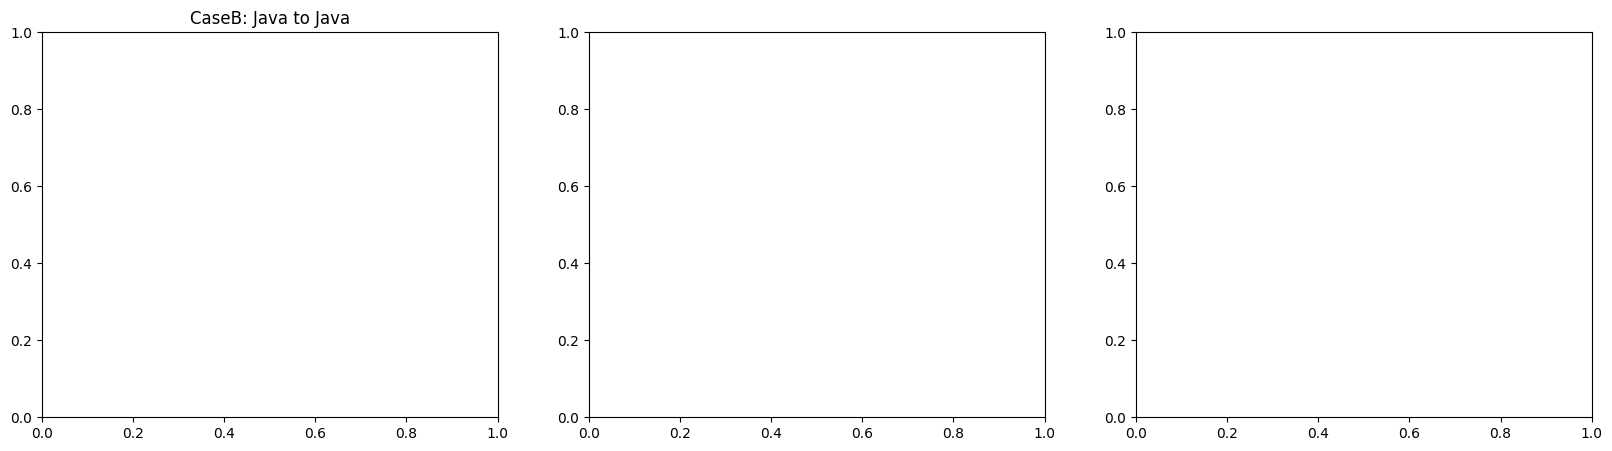

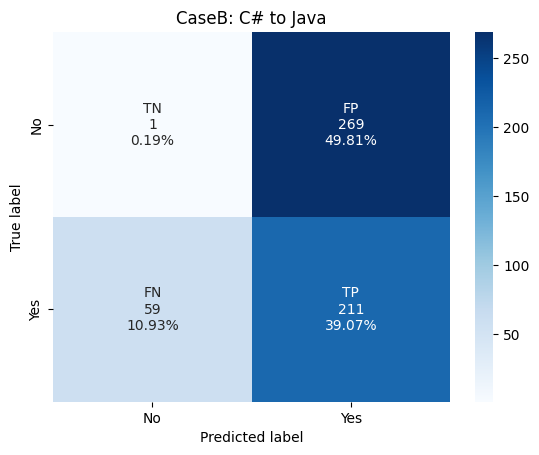

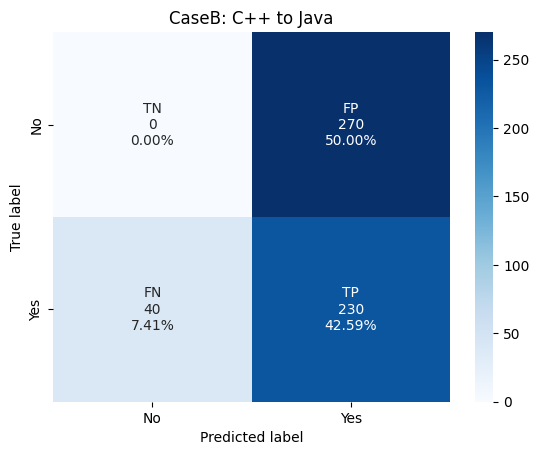

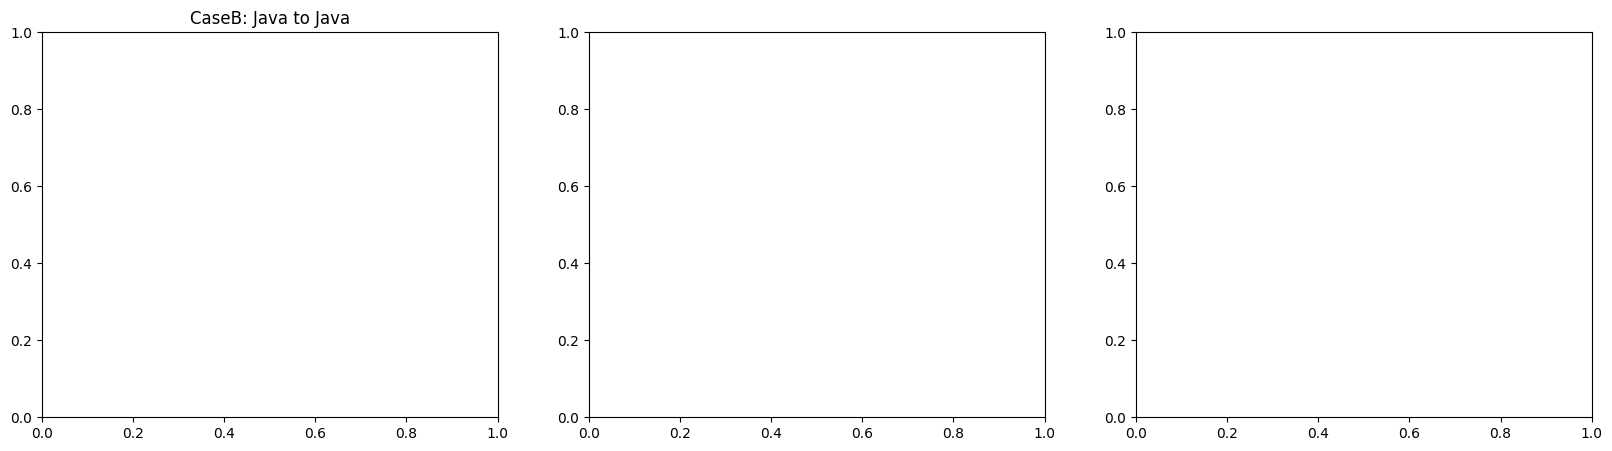

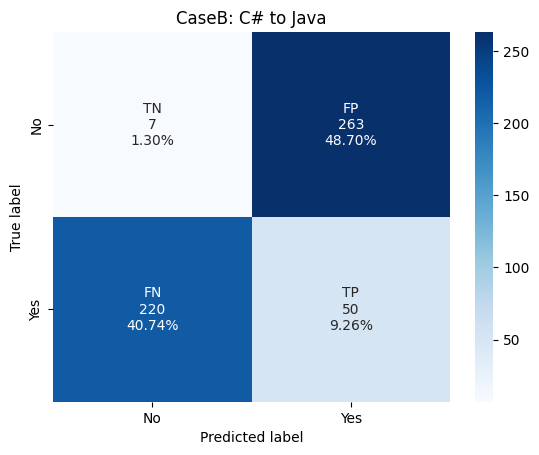

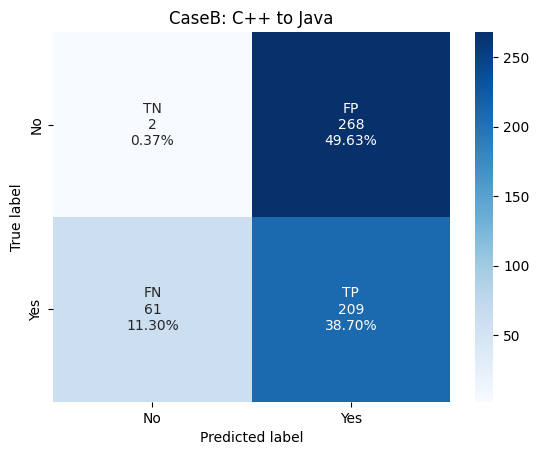

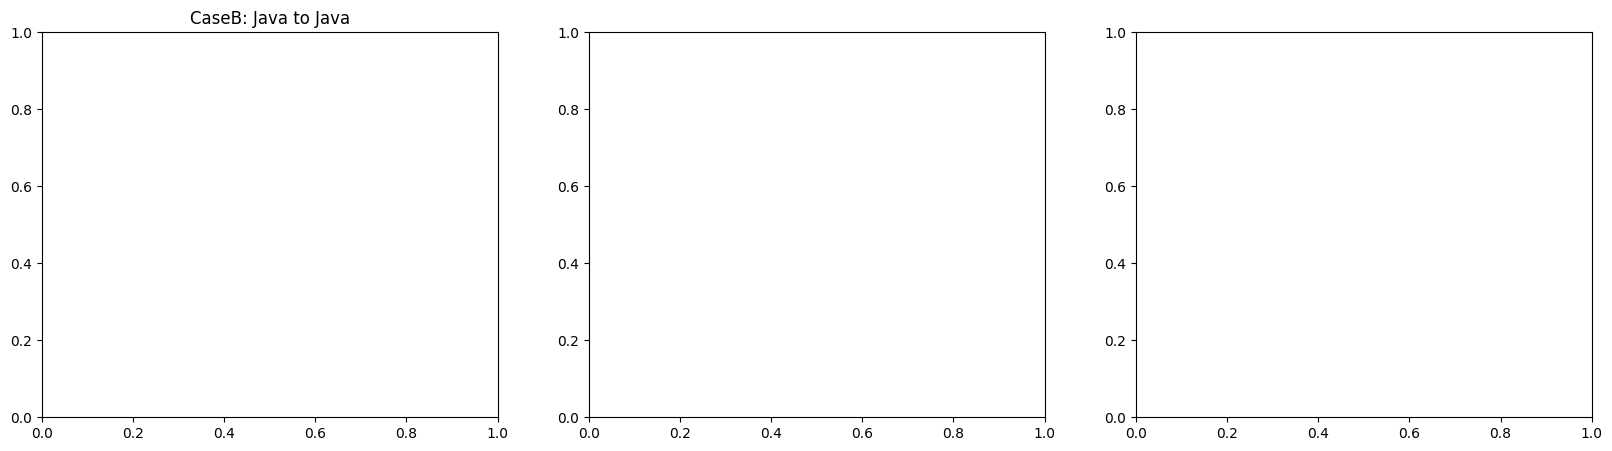

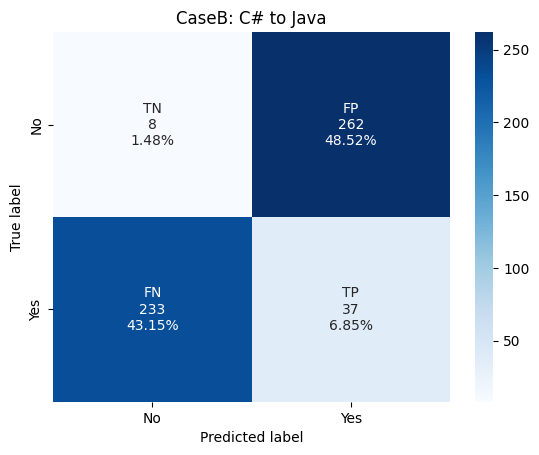

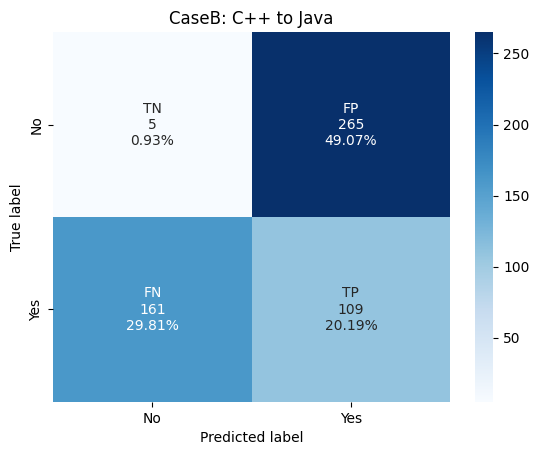

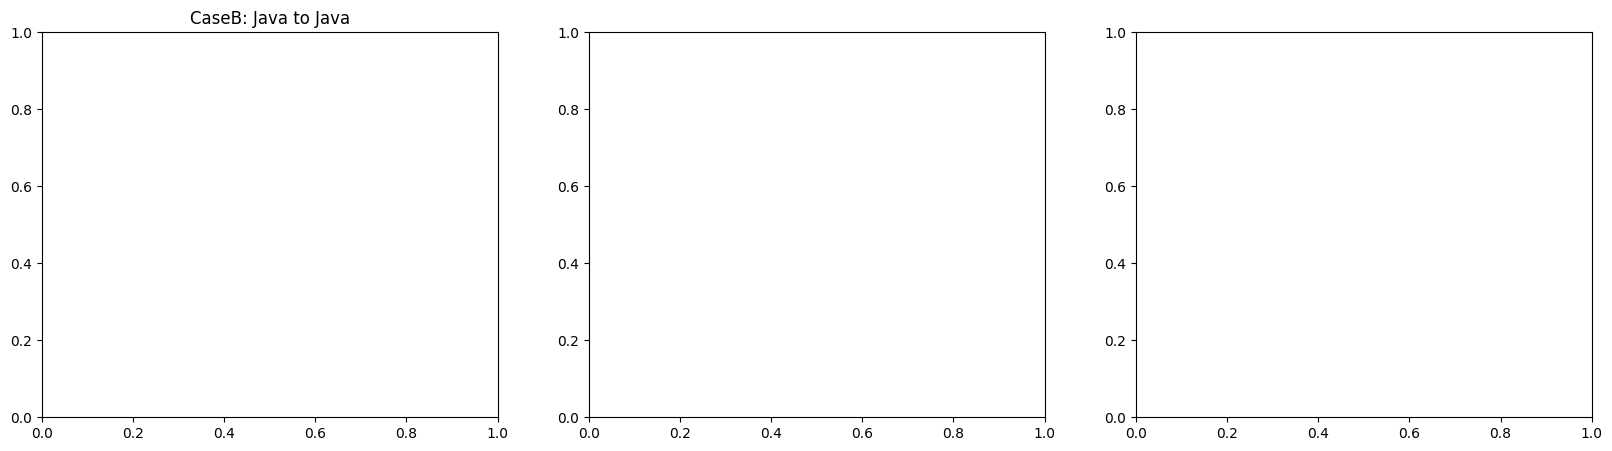

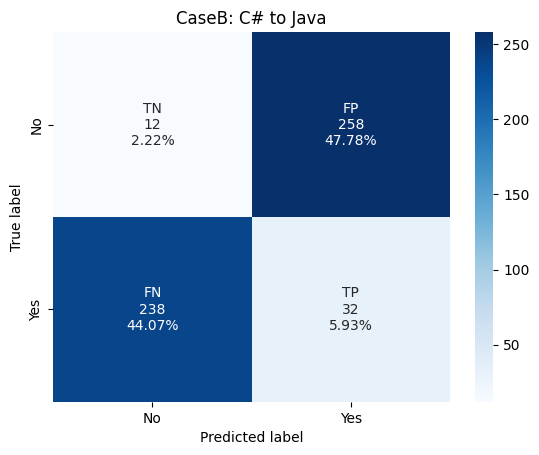

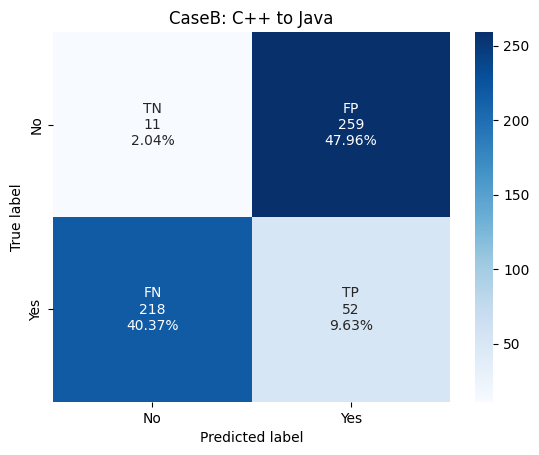

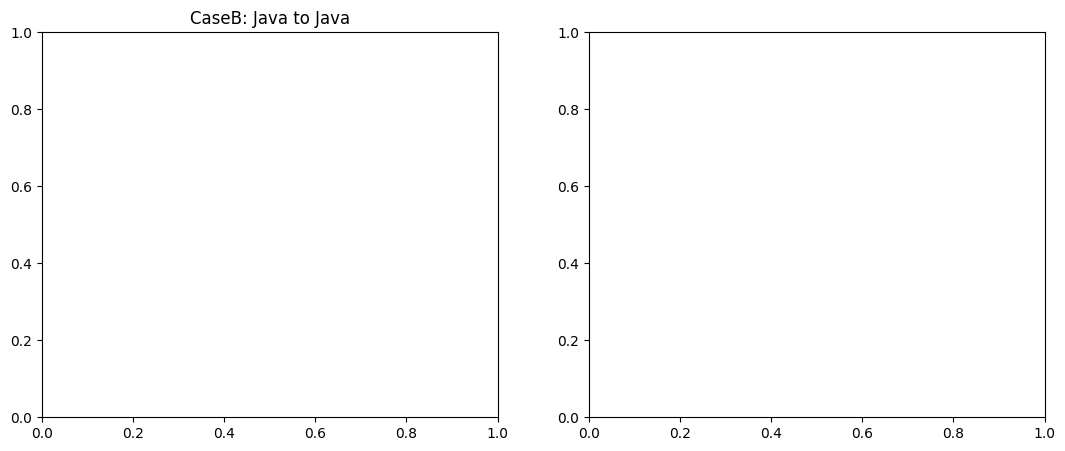

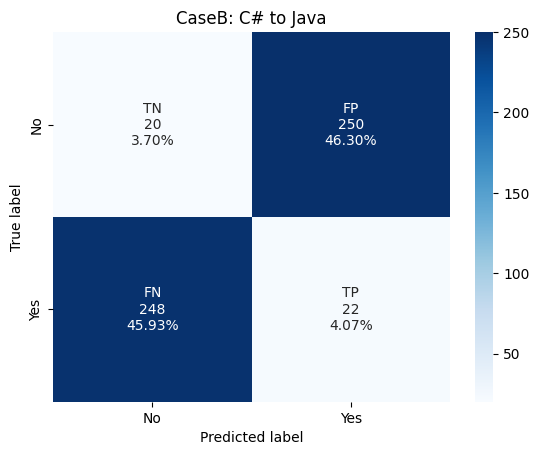

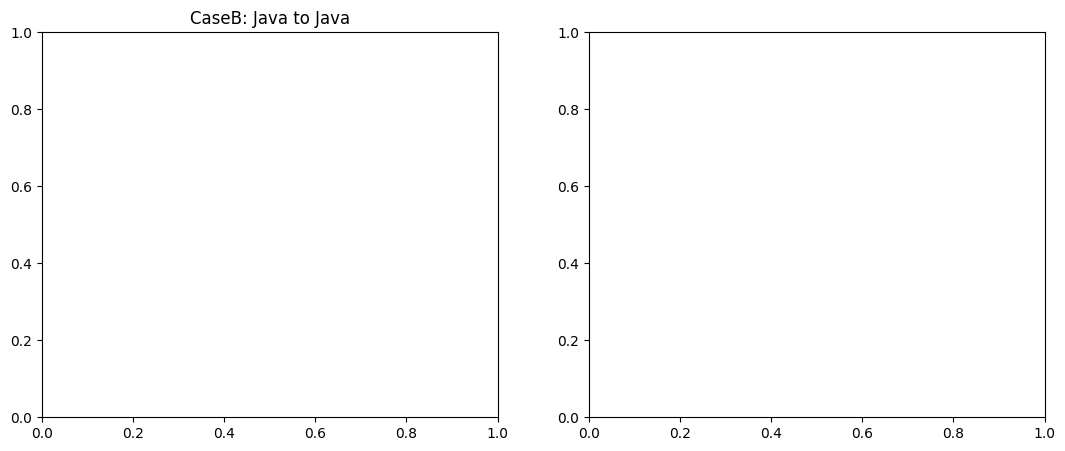

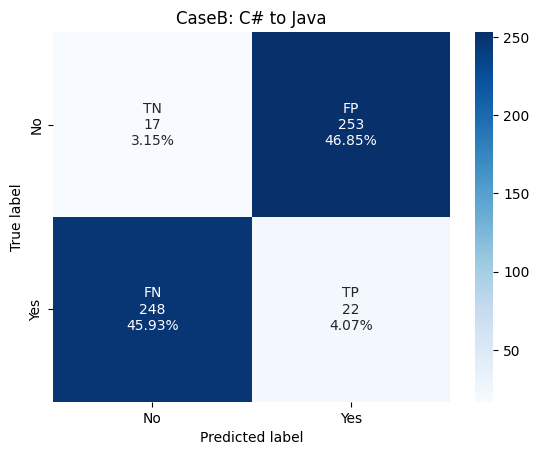

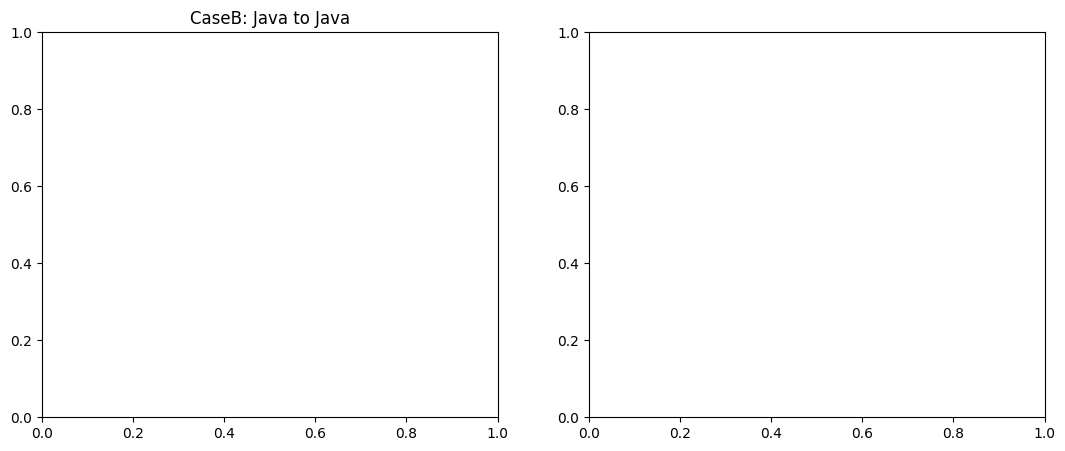

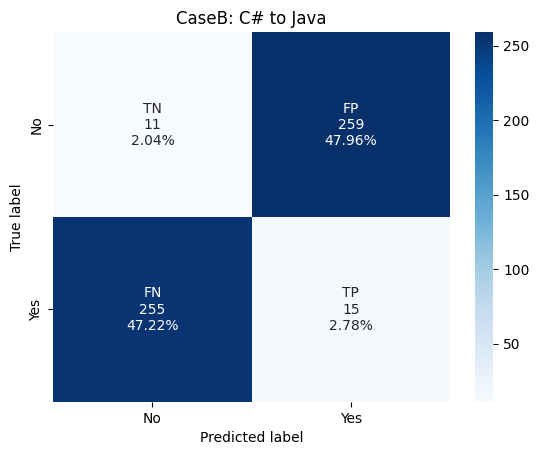

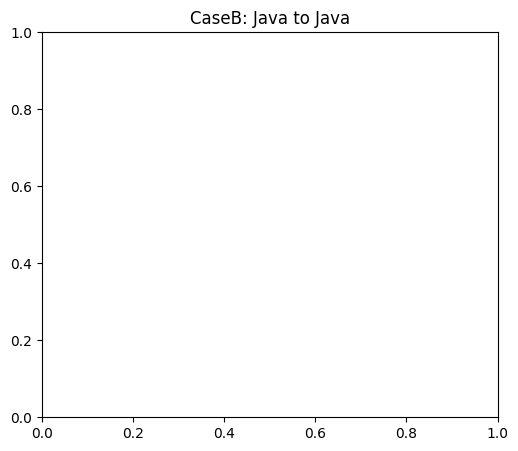

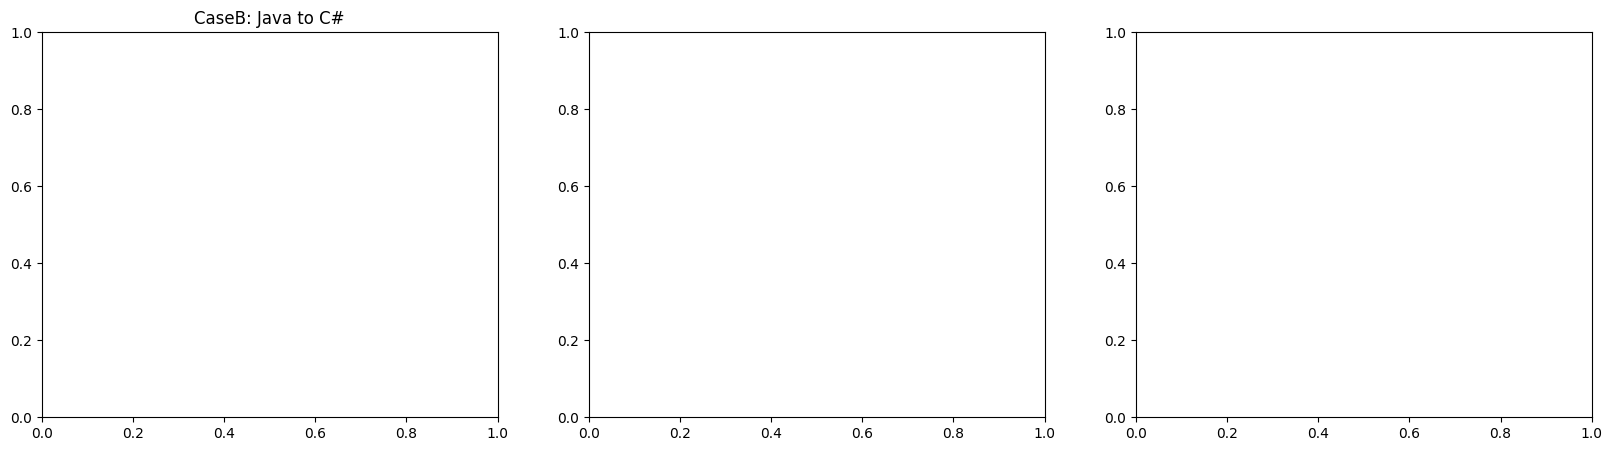

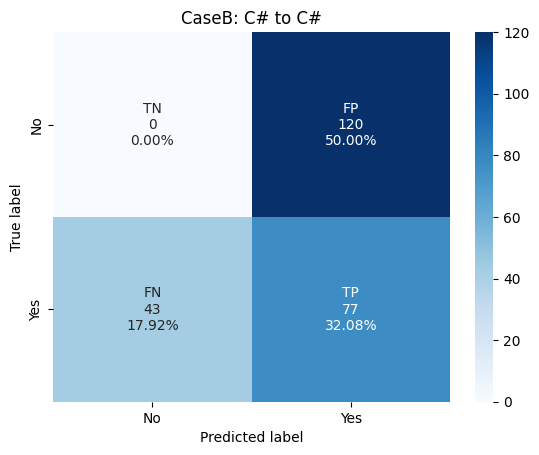

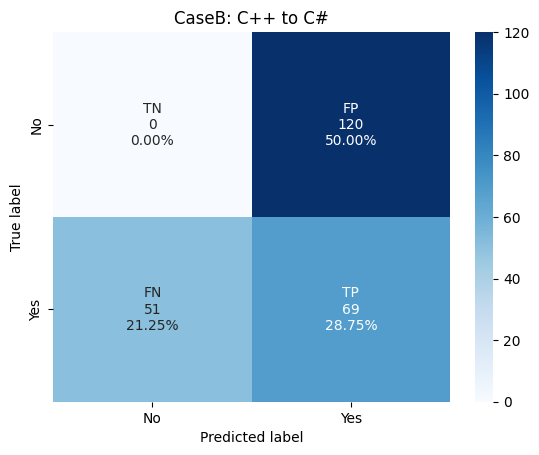

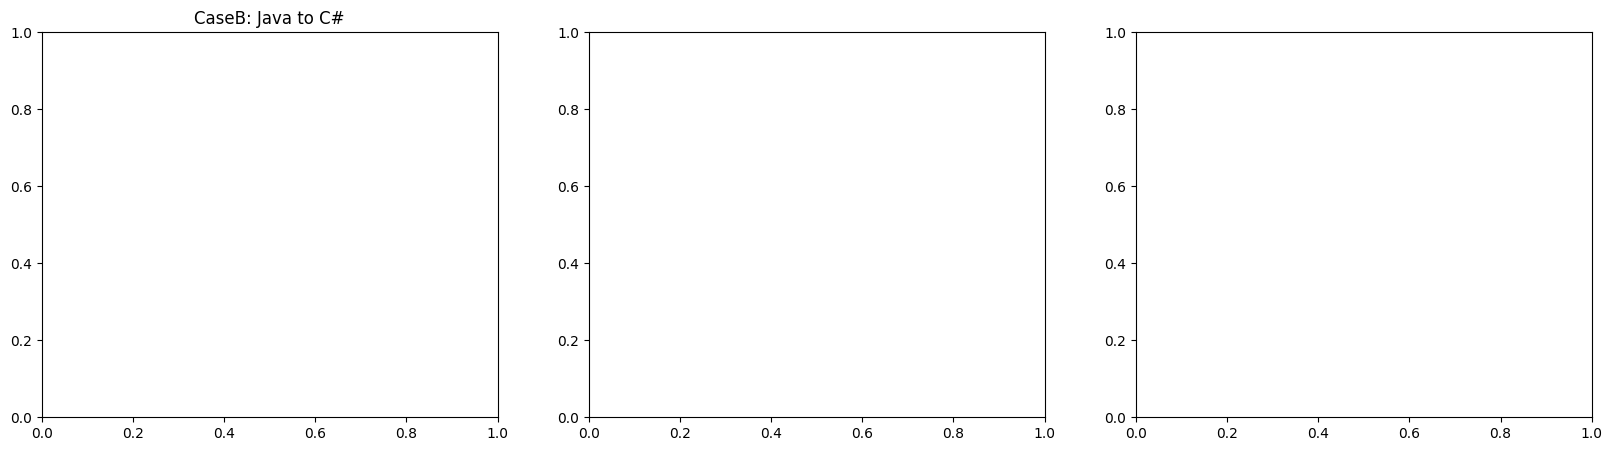

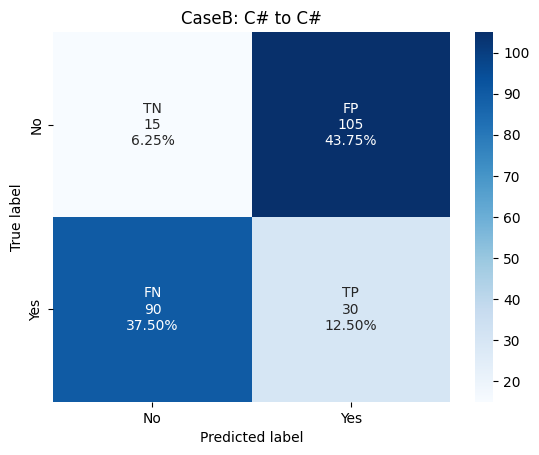

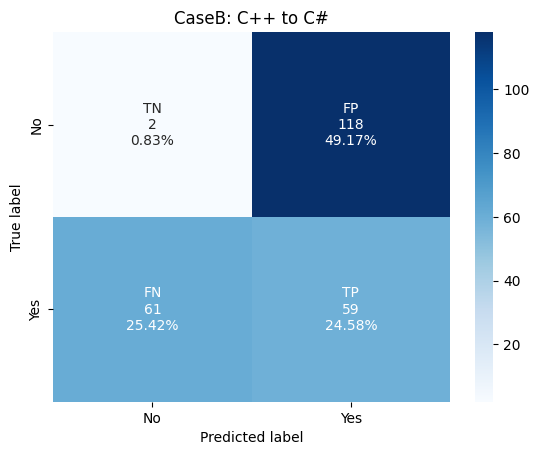

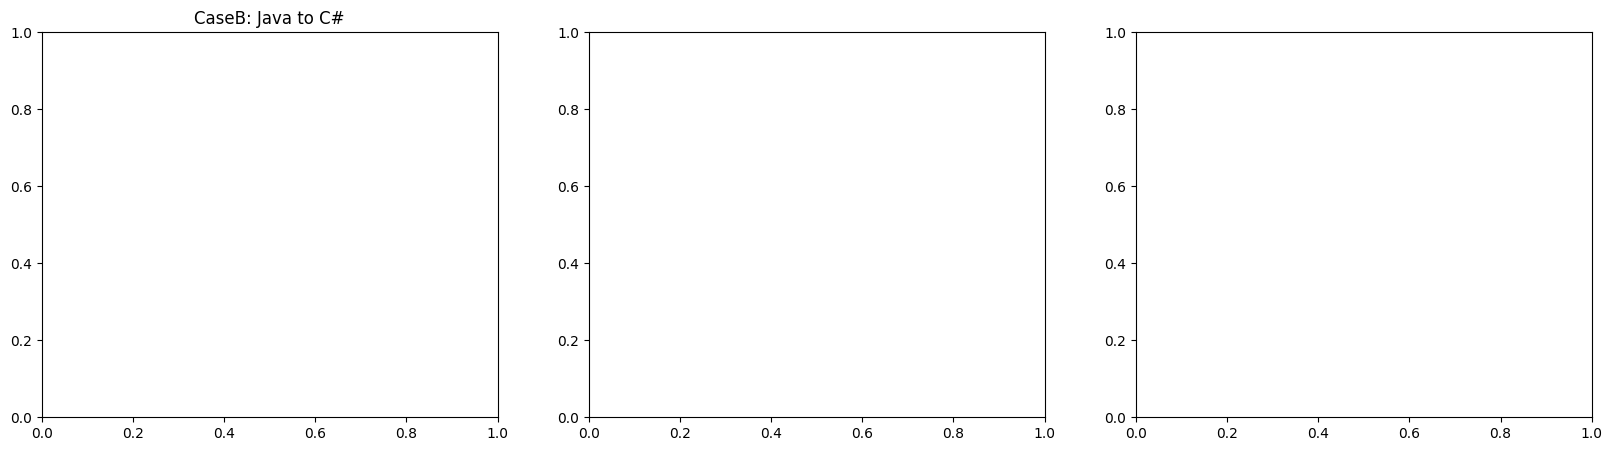

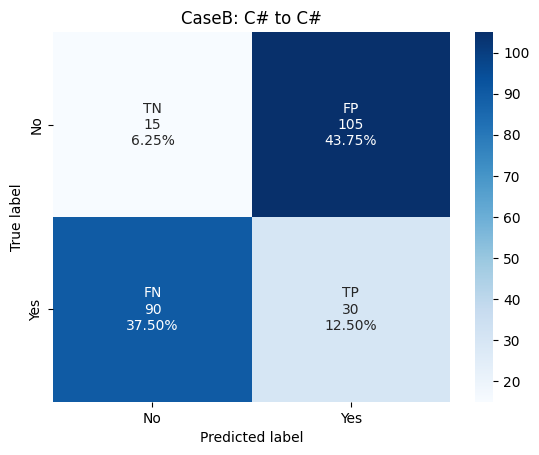

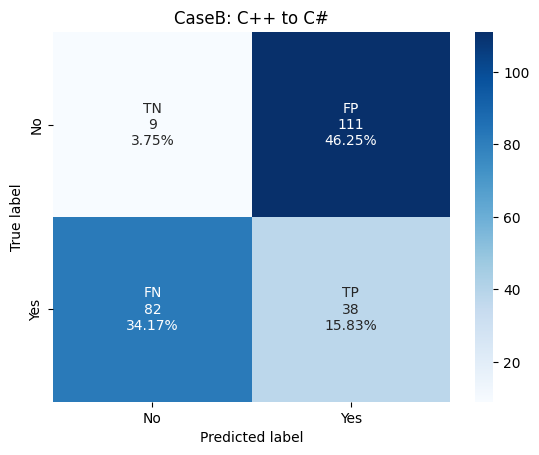

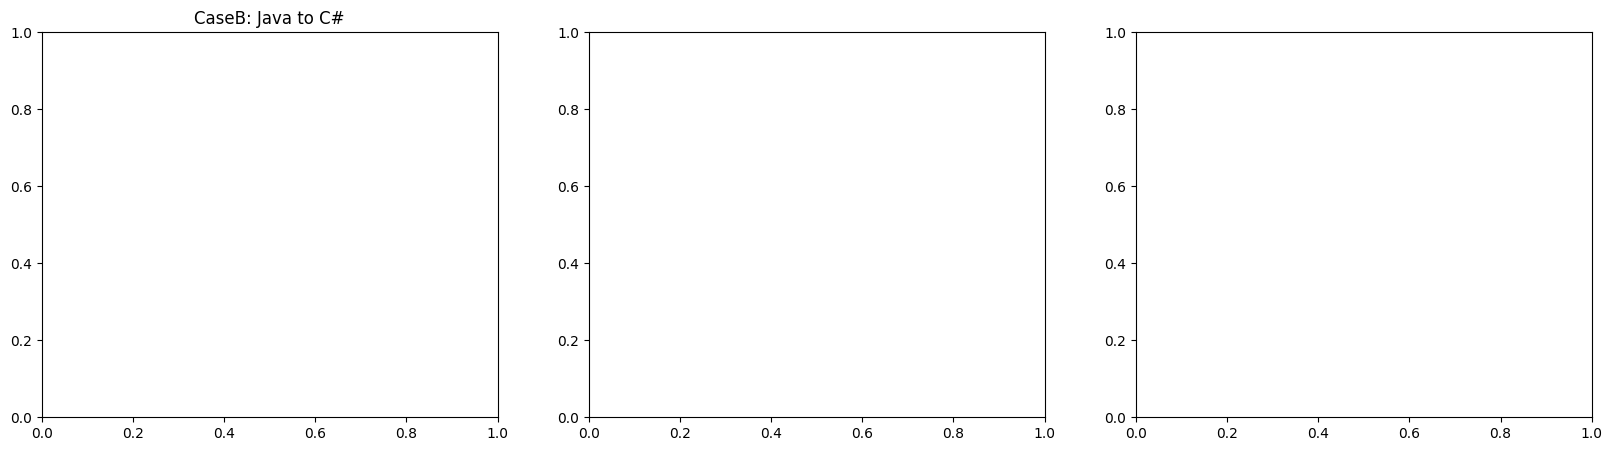

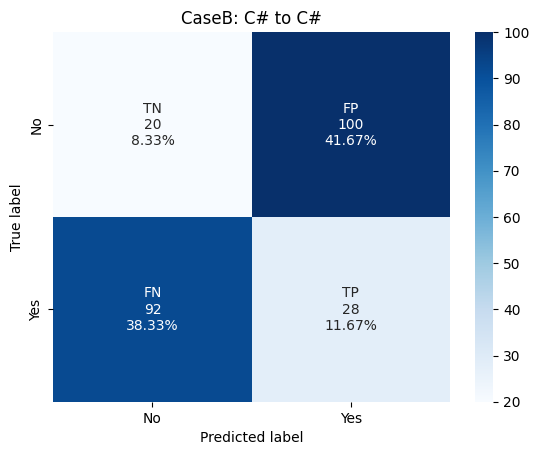

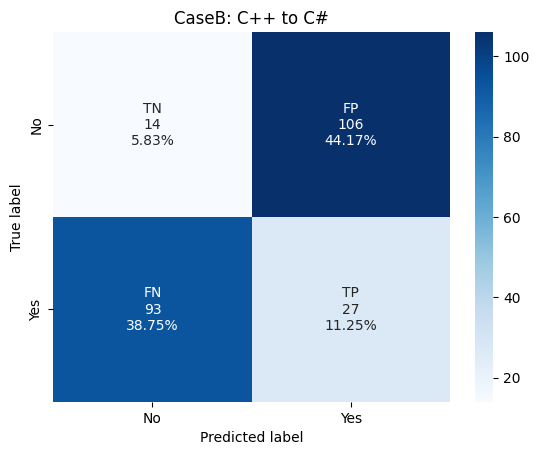

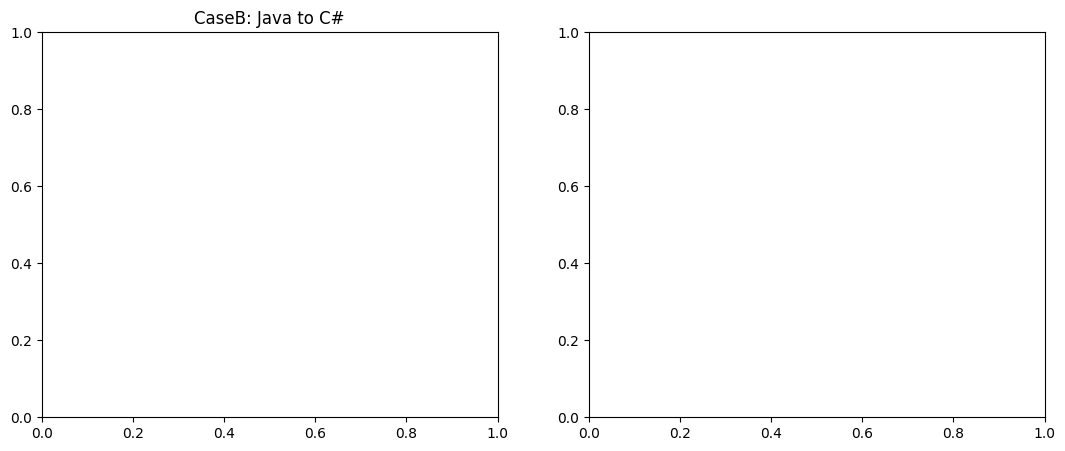

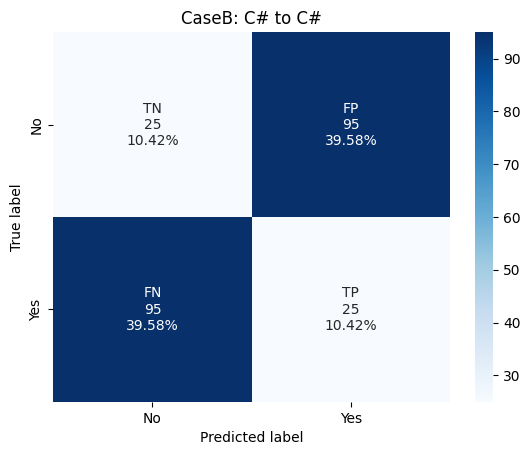

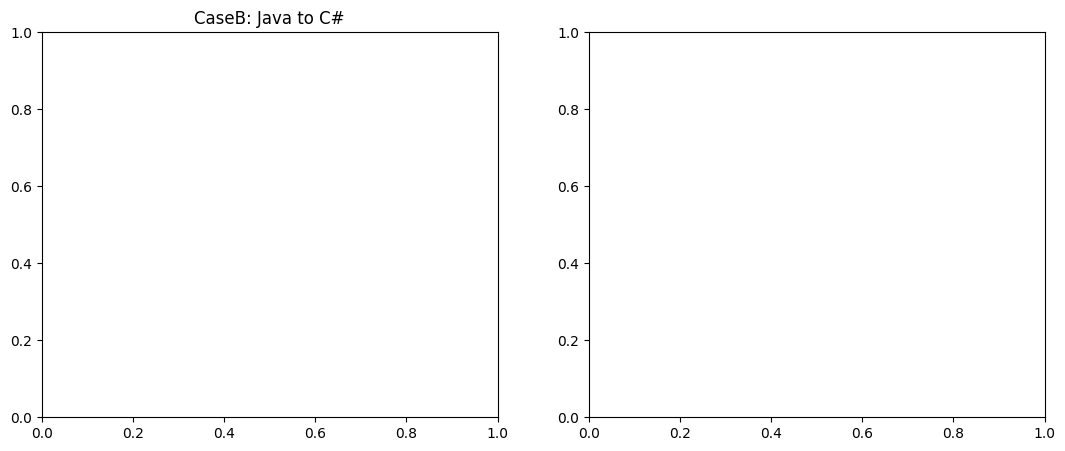

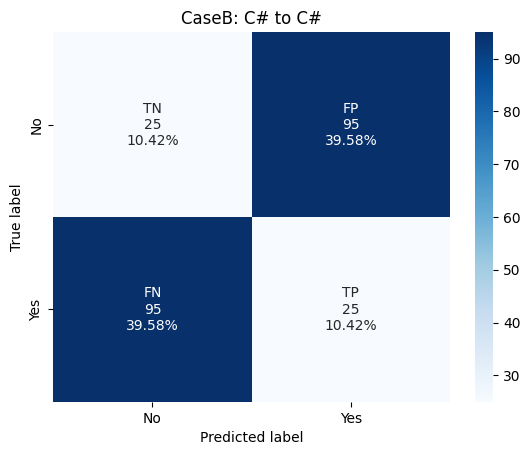

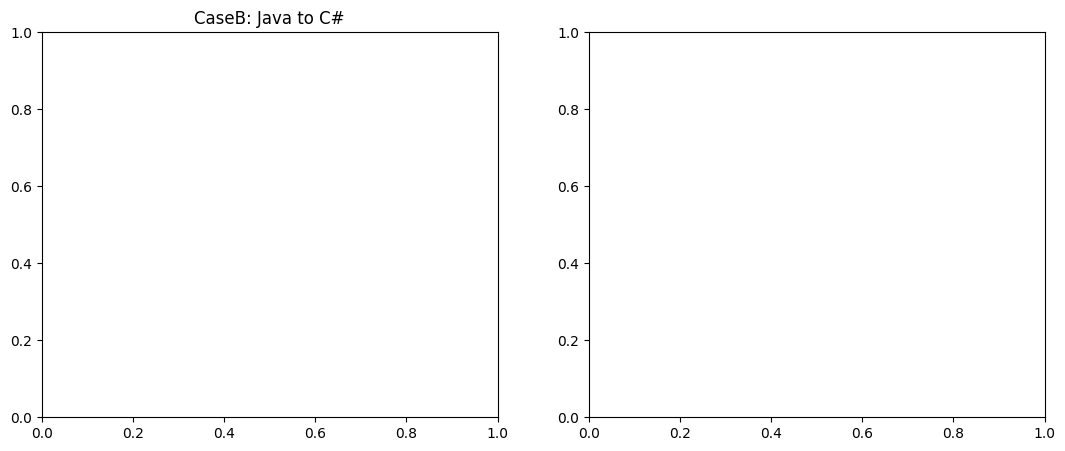

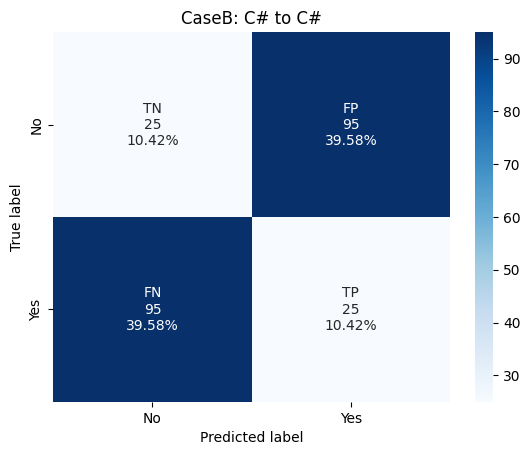

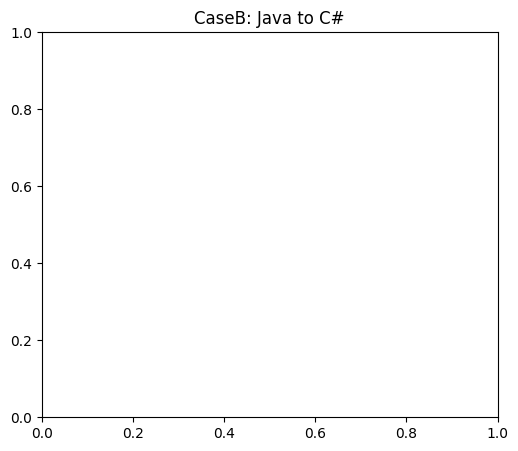

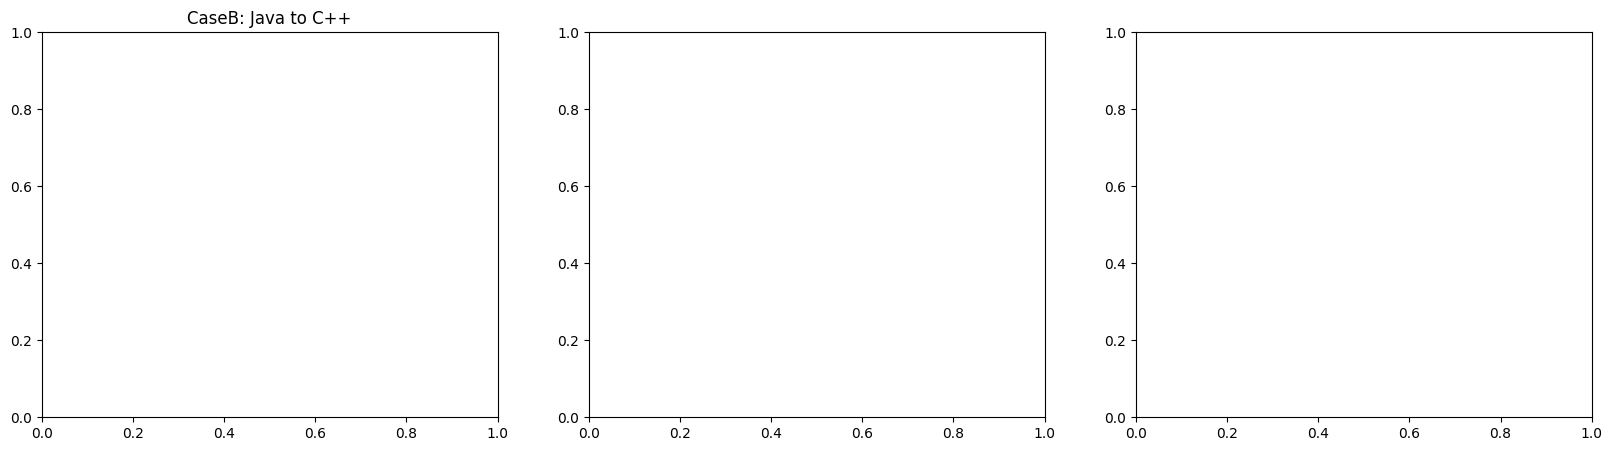

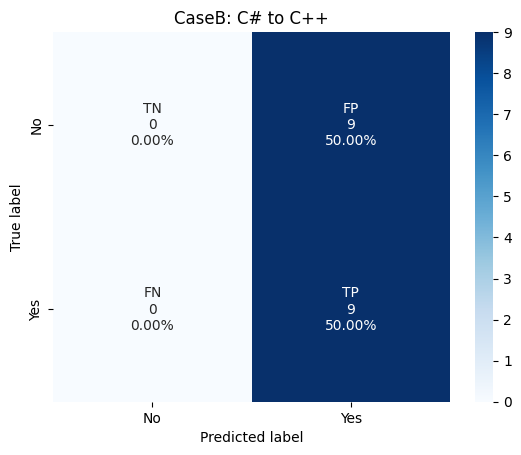

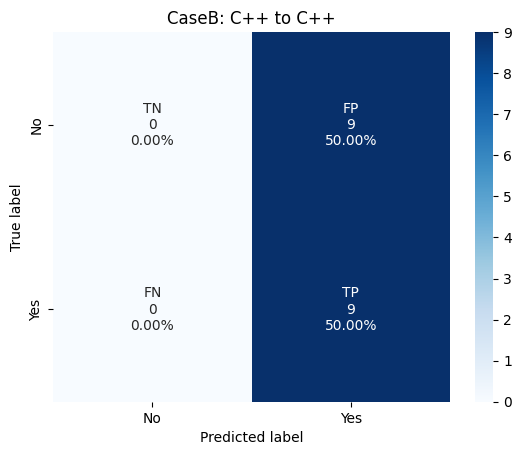

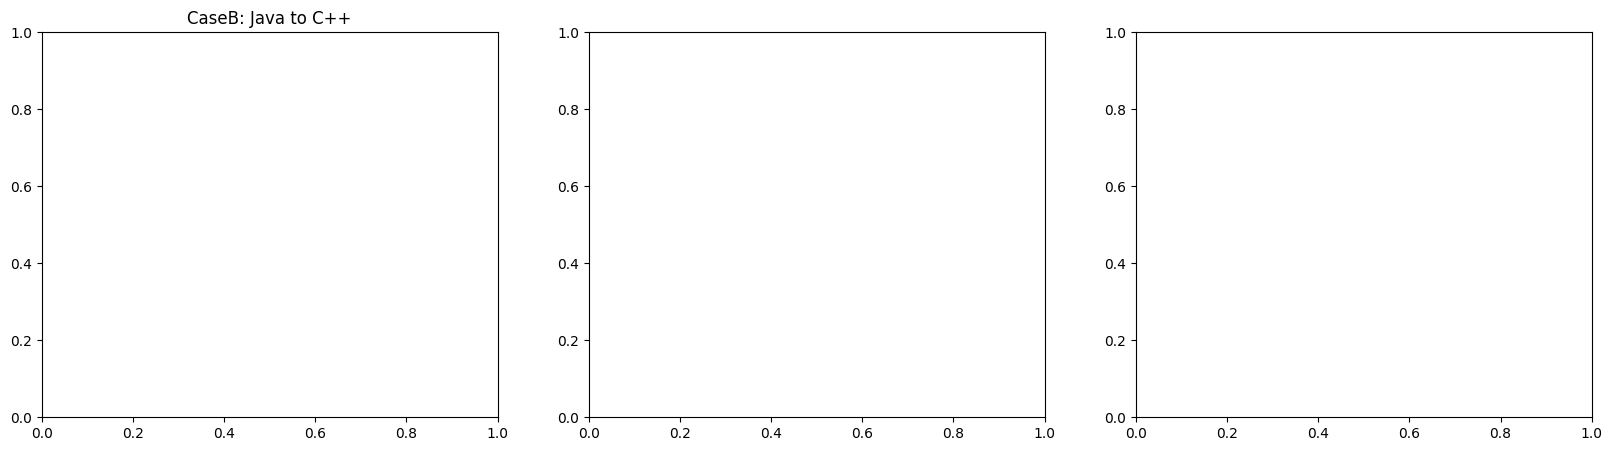

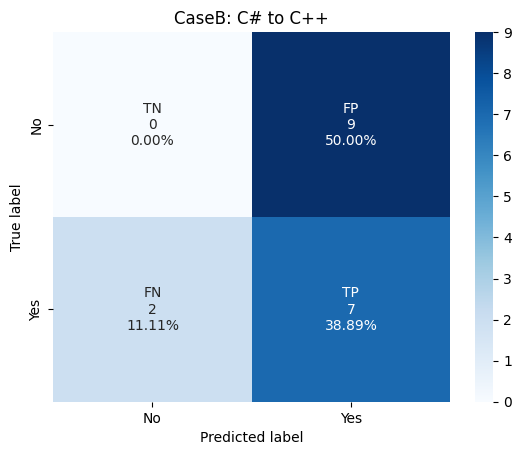

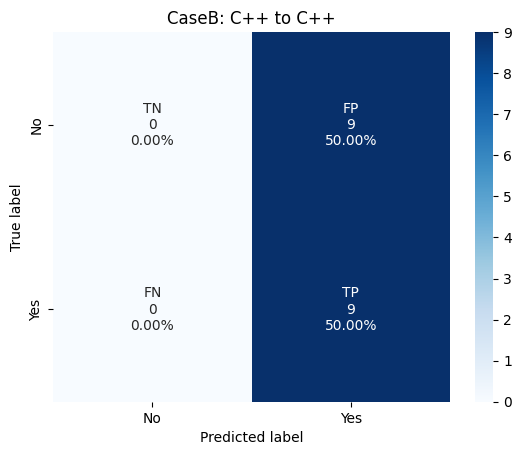

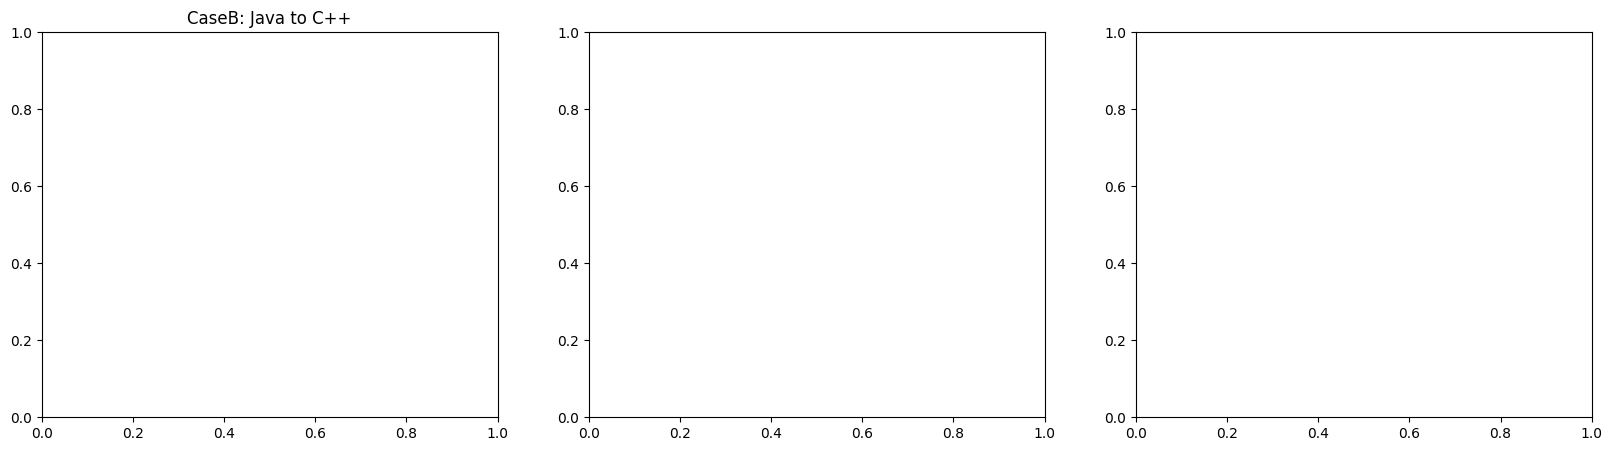

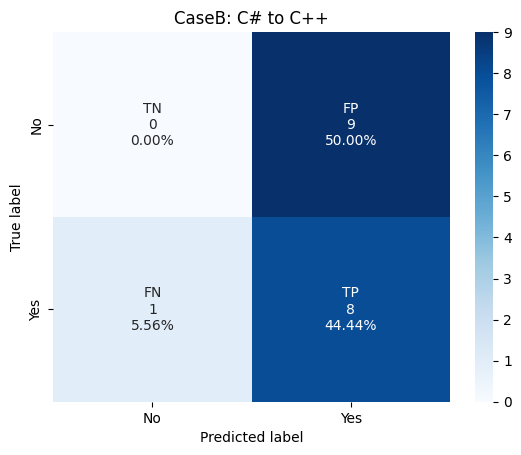

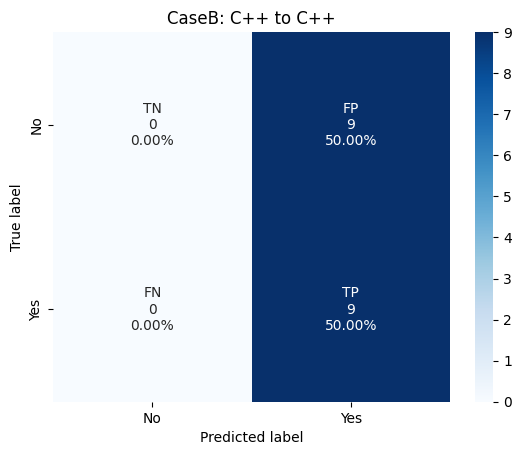

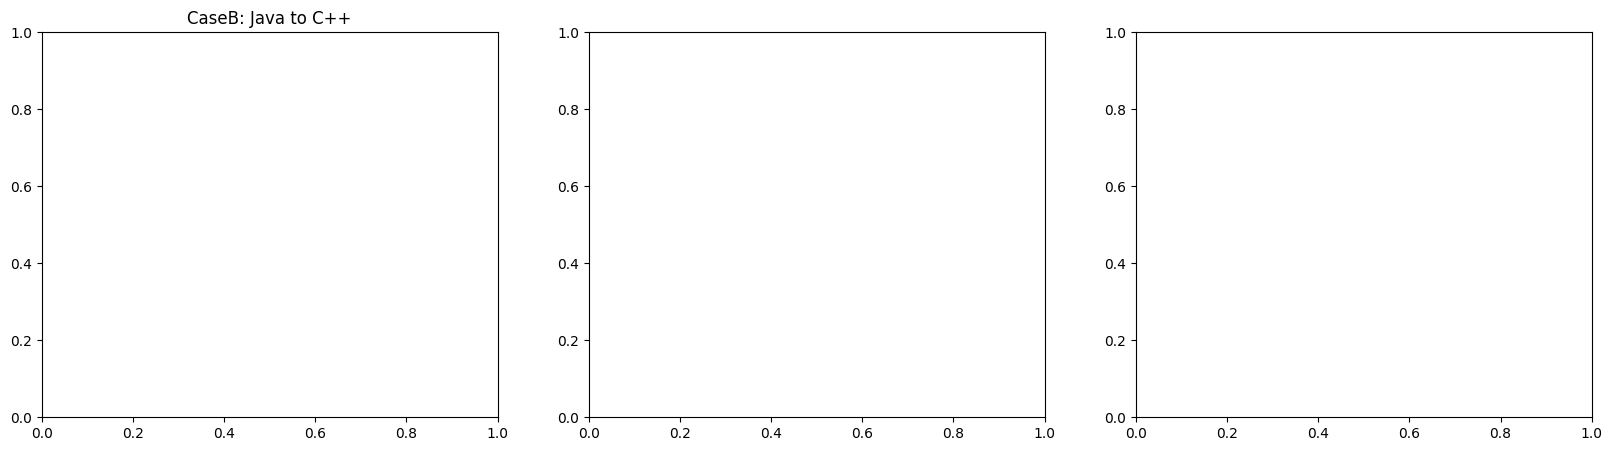

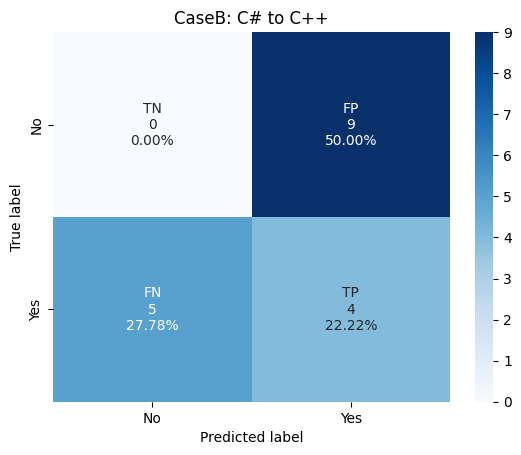

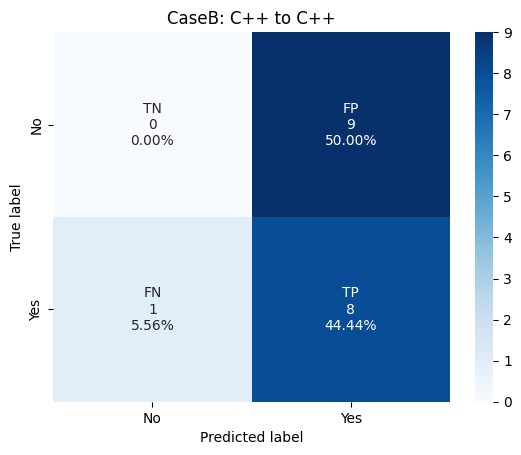

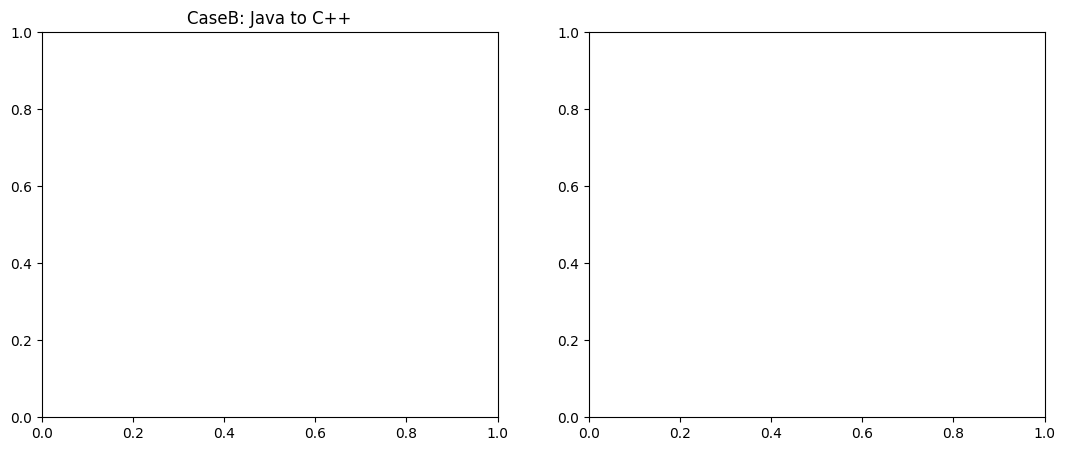

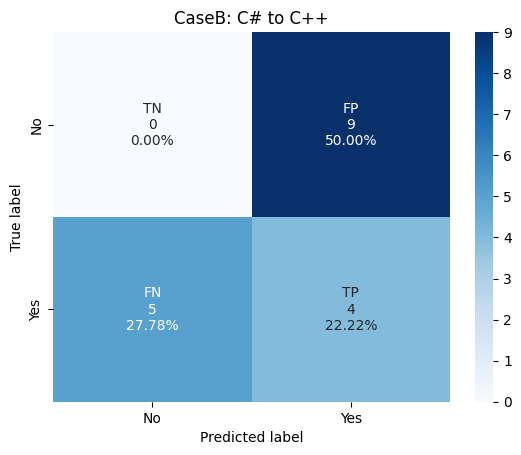

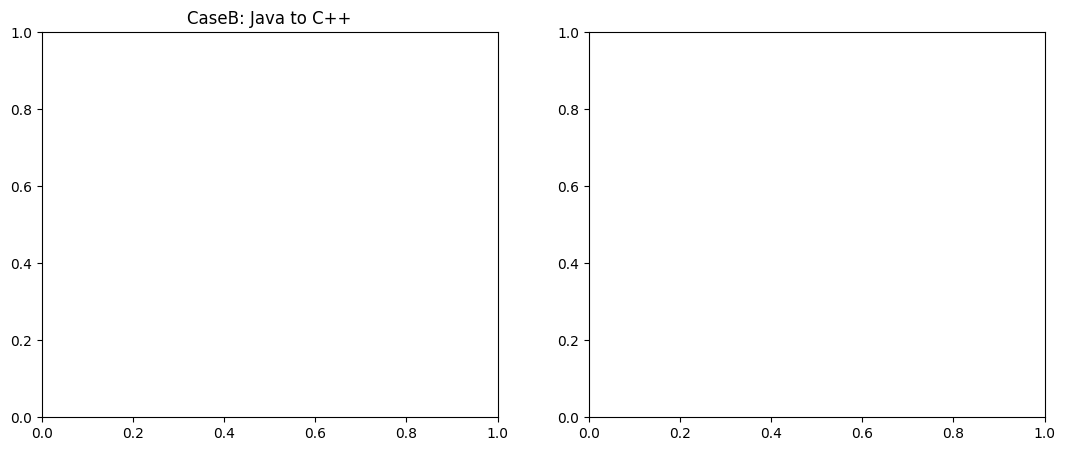

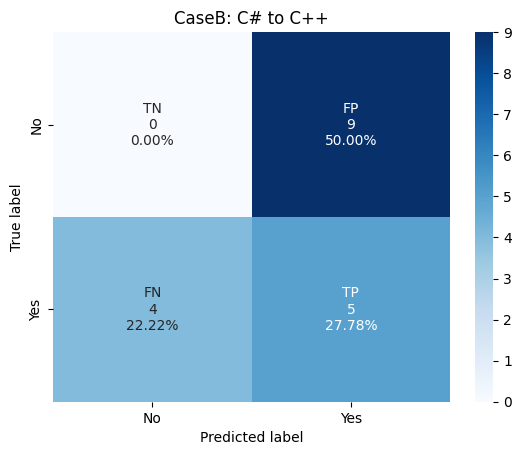

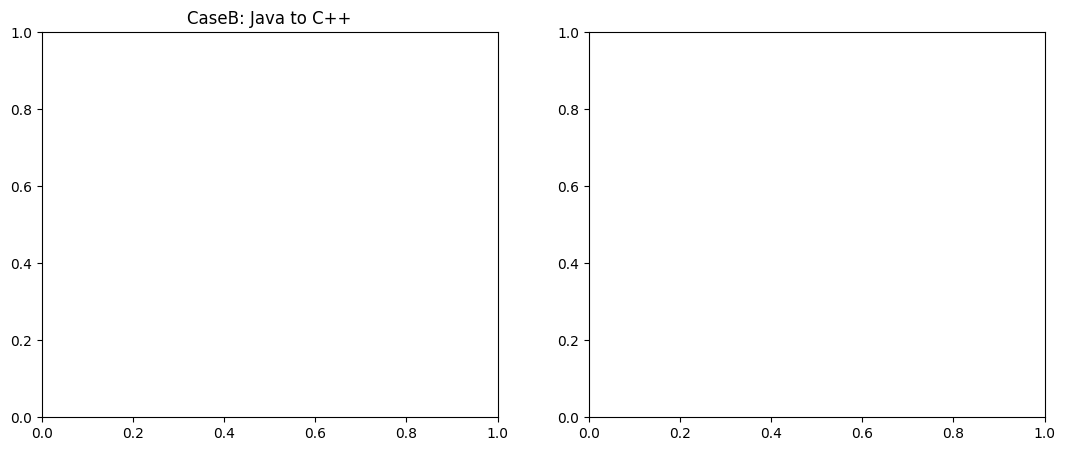

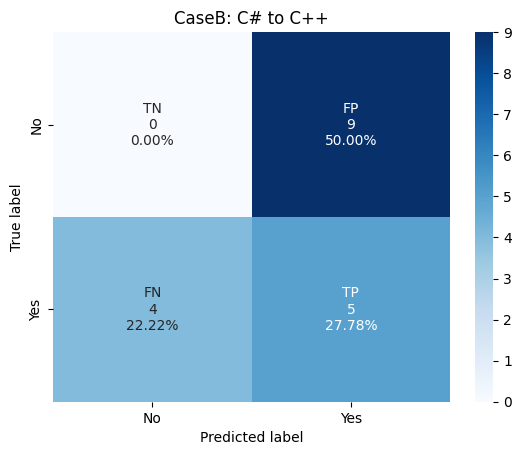

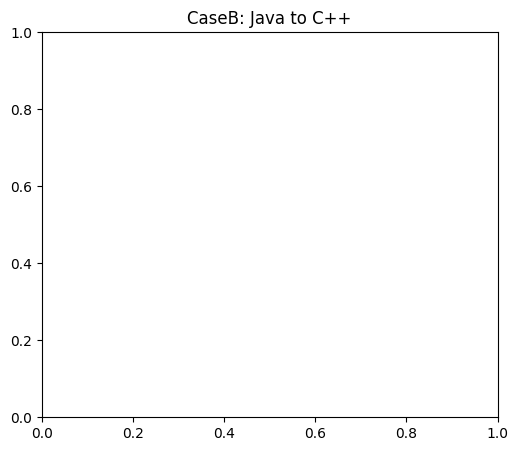

In [ ]:
# result = transfer_learning_n_samples(['Python'], 'Java', 'Test_1', SMELLS[0], 'perceptron1')
results = []

for smell in SMELLS:
    for target_language in LANGUAGES:
        results.append(transfer_learning_n_samples(LANGUAGES, target_language, 'Test_1', smell, 'perceptron1'))

In [ ]:
# Saving the results of those models when evaluated using Test datasets
for result in results:
    append_data_file(result)

# RQ4: How complex should the deep learning models be for effectively detecting code smells?

## Function

In [ ]:
def cnn(padding):
    np.random.seed(RANDOM_STATE)
    model = Sequential()
    model.add(Embedding(20000, 8, input_length=padding))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

## Training CNN models

In [ ]:
model_n_dict = {}
for smell in SMELLS:
    model_n_dict[smell['name']] = {}
    train_all_samples(LANGUAGES, 'Train_1', smell, cnn, 'cnn1', model_n_dict)

training model: Java CaseB Train_1 cnn1


In [ ]:
# train_n_samples(['Python'], [2, 4, 8, 16, 32, 64, 128, 256], 'Train_1', SMELLS[0], cnn, 'cnn1')

for smell in SMELLS:
    train_n_samples(LANGUAGES, [2, 4, 8, 16, 32, 64, 128, 256], 'Train_1', smell, cnn, 'cnn1')

## Transfer Learning

In [ ]:
# result = transfer_learning_n_samples(['Python'], 'Java', 'Test_1', SMELLS[0], 'cnn1')

results = []

for smell in SMELLS:
    for target_language in LANGUAGES:
        results.append(transfer_learning_n_samples(LANGUAGES, target_language, 'Test_1', smell, 'cnn1'))

In [ ]:
# Saving the results of those models when evaluated using Test datasets
# append_data_file(result)

for result in results:
    append_data_file(result)

# Save your files to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cp -av code_smells_datasets/ "/content/gdrive/MyDrive/Colab Notebooks/content"
%cp -av models/ "/content/gdrive/MyDrive/Colab Notebooks/content"
%cp -av results/ "/content/gdrive/MyDrive/Colab Notebooks/content"
%cp -av sample_data/ "/content/gdrive/MyDrive/Colab Notebooks/content"